In [1]:
from scipy.stats import expon
from scipy.stats import uniform
from scipy.stats import norm
from scipy.stats import multivariate_normal
from numpy.random import multinomial
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def expo_quad_kernel(theta0,theta1,xn,xm): # 1,0.1
    return theta0*np.exp(-theta1/2*np.sum((xn - xm)**2))

In [3]:
def sigmoid(x): #"Numerically-stable sigmoid function."
    result=np.array([])
    for x_i in x:
        if x_i >= 0:
            z = np.exp(-x_i)
            result=np.append(result, 1 / (1 + z))
        else:
            z = np.exp(x_i)
            result=np.append(result, z / (1 + z))
    return result

In [4]:
def sample_GP(theta0,theta1,x):# mean=[0,0...0] cov=expo()
    N=len(x)
    cov=np.zeros((N,N))
    for i in range(N):
        for j in range(i+1):
            cov[i][j]=expo_quad_kernel(theta0,theta1,x[i],x[j])
            if i!=j:
                cov[j][i]=cov[i][j]
    return multivariate_normal.rvs(np.zeros(N),cov)

In [5]:
def SGP_intensity(measure_sup,theta0,theta1,x):
    return measure_sup*sigmoid(sample_GP(theta0,theta1,x))

In [6]:
def GP_regression(xi,yi,theta0,theta1,noise_var,rang,num_points):
    N=len(xi)
    cov_K=np.zeros((N,N))
    for i in range(N):
        for j in range(i,N):
            cov_K[i][j]=expo_quad_kernel(theta0,theta1,xi[i],xi[j])
            cov_K[j][i]=cov_K[i][j]
    min_eig=np.min(np.real(np.linalg.eigvals(cov_K))) # numerical float truncation error refine
    while(min_eig<0):
        cov_K += -10*min_eig*np.eye(N)
        min_eig=np.min(np.real(np.linalg.eigvals(cov_K)))
    
    cov_K_noise=cov_K+np.eye(N)*noise_var
    
    x1=np.linspace(0,rang,num_points+1)      # prediction points, integer is to make it easy
    M=len(x1)-1
    mean=np.zeros((1,M))[0]
    posterior_cov=np.zeros((M,M))
    k_matrix=np.zeros((M,N))
    k_matrix_pre=np.zeros((M,M))
    for i in range(M):
        for j in range(N):
            k_matrix[i][j]=expo_quad_kernel(theta0,theta1,x1[i],xi[j])
    k_C=np.dot(k_matrix,np.linalg.inv(cov_K_noise))
    mean=np.dot(k_C,yi)
    for i in range(M):
        for j in range(i,M):
            k_matrix_pre[i][j]=expo_quad_kernel(theta0,theta1,x1[i],x1[j])
            k_matrix_pre[j][i]=k_matrix_pre[i][j]
    posterior_cov=k_matrix_pre-np.dot(k_C,k_matrix.T)+np.eye(M)*noise_var
    min_eig=np.min(np.real(np.linalg.eigvals(posterior_cov))) # numerical float truncation error refine
    while(min_eig<0):
        posterior_cov += -10*min_eig*np.eye(posterior_cov.shape[0])
        min_eig=np.min(np.real(np.linalg.eigvals(posterior_cov)))
    return x1[:num_points],mean, posterior_cov

In [31]:
def GP_regression_one_pred(xi,yi,theta0,theta1,noise_var,x_pred):
    N=len(xi)
    cov_K=np.zeros((N,N))
    for i in range(N):
        for j in range(i,N):
            cov_K[i][j]=expo_quad_kernel(theta0,theta1,xi[i],xi[j])
            if j!=i:
                cov_K[j][i]=cov_K[i][j]

    cov_K_noise=cov_K+np.eye(N)*noise_var
    min_eig=np.min(np.real(np.linalg.eigvals(cov_K_noise))) # numerical float truncation error refine
    i=0
    while(min_eig<0):
        cov_K_noise += -10*min_eig*np.eye(N)
        i+=1
        min_eig=np.min(np.real(np.linalg.eigvals(cov_K_noise)))
        if i>10: break
    
    # prediction point
    k_vec=np.array([])
    for i in range(N):
        k_vec=np.append(k_vec,expo_quad_kernel(theta0,theta1,x_pred,xi[i]))
    k_C=np.dot(k_vec,np.linalg.inv(cov_K_noise))
    mean=np.dot(k_C,yi)
    var=theta0+noise_var-np.dot(k_C,k_vec)
    if var<0:var=0.0001
    std_dev=np.sqrt(var)
    
    return mean,std_dev

In [32]:
# def inhomo_poisson_simulation(theta0,theta1,measure_sup,T):
#     t=0
#     points_homo=[]
#     points_inhomo=[]
#     D_list=[]
#     while(t<T):
#         points_homo.append(t)
#         r=expon.rvs(scale=1/measure_sup) #scale=1/lamda
#         t+=r
#     del points_homo[0]
    
#     N=len(points_homo)
#     intensity_N=SGP_intensity(measure_sup,theta0,theta1,points_homo)
#     for i in range(N):
#         D=uniform.rvs(loc=0,scale=1)
#         D_list.append(D*measure_sup)
#         if D*measure_sup<=intensity_N[i]:
#             points_inhomo.append(points_homo[i])
#     return points_inhomo,points_homo,intensity_N,D_list
def inhomo_simulation(measure,delta_t,measure_sup,T):
    t=0
    points_homo=[]
    points_inhomo=[]
    points_thinned=[]
    while(t<T):
        points_homo.append(t)
        r=expon.rvs(scale=1/measure_sup) #scale=1/lamda
        t+=r
        if t>=T: break
        D=uniform.rvs(loc=0,scale=1)
        if D*measure_sup<=measure[int(t/delta_t)]:
            points_inhomo.append(t)
        else:
            points_thinned.append(t)
    if points_inhomo[-1]>T:
        del points_inhomo[-1]
    del points_homo[0]
    return points_inhomo,points_thinned

## simulation

In [105]:
measure_sup=1   #supreme

In [106]:
T=100

In [107]:
bin_num=1000

In [108]:
x=np.linspace(T/bin_num/2,T-T/bin_num/2,bin_num)

In [109]:
intensity=SGP_intensity(measure_sup,1,0.01,x) ## theta0,theta1

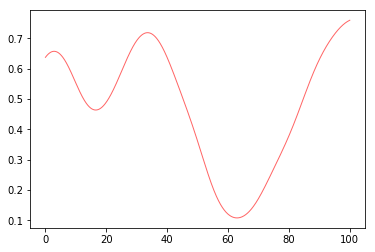

In [110]:
plt.figure(1)                # the first figure
plt.subplot(111)             # the first subplot in the first figure
plt.plot(x,intensity,'r-',lw=1,alpha=0.6)
plt.show()

In [111]:
points_inhomo,points_thinned=inhomo_simulation(intensity,T/len(intensity),measure_sup,T)

In [112]:
len(points_inhomo)

49

In [113]:
len(points_thinned)

50

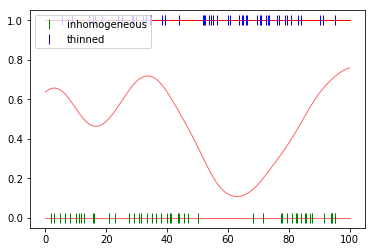

In [114]:
plt.figure(1)                # the first figure
plt.subplot(111)             # the first subplot in the first figure
plt.plot([0,T],[0,0],'r-',lw=1,alpha=0.6)
plt.plot([0,T],[measure_sup,measure_sup],'r-',lw=1)
plt.plot(x,intensity,'r-',lw=1,alpha=0.6)
plt.plot(points_inhomo,np.zeros(len(points_inhomo)),linestyle='None', marker='|', color='g', markersize=10,label='inhomogeneous')
plt.plot(points_thinned,1*np.ones(len(points_thinned)),linestyle='None', marker='|', color='b', markersize=10,label='thinned')
plt.legend()
plt.show()

## MCMC inference

In [115]:
def sampling_M(M,s_m,g_mk,measure_sup,T,theta0,theta1,noise_var):
    temp=uniform.rvs(0,1)
    if temp<=0.5: ## M-->M+1
        s_prime=uniform.rvs(0,T) # propose a s'
        mean_s_prime,std_s_prime=GP_regression_one_pred(np.array(points_inhomo+list(s_m)),g_mk,theta0,theta1,noise_var,s_prime)
        g_s_prime=norm.rvs(mean_s_prime,std_s_prime) # propose a g(s')
        accept_rate=T*measure_sup/(M+1)/(1+np.exp(g_s_prime))
        temp_1=uniform.rvs(0,1)
        if temp_1<accept_rate:
            M=M+1
            s_m=np.append(s_m,s_prime)
            g_mk=np.append(g_mk,g_s_prime)
            assert len(s_m)==M
            assert len(g_mk)==M+K
    else:   ## M-->M-1
        index=np.where(multinomial(1,[1/M]*M)==1)[0][0]
        s_prime=s_m[index]
        g_s_prime=g_mk[K+index]
        accept_rate=M*(1+np.exp(g_s_prime))/T/measure_sup
        temp_1=uniform.rvs(0,1)
        if temp_1<accept_rate:
            M=M-1
            s_m=np.delete(s_m,index)
            g_mk=np.delete(g_mk,K+index)
            assert len(s_m)==M
            assert len(g_mk)==M+K
    return M, s_m, g_mk

In [116]:
def sampling_s_m(M,s_m,g_mk,measure_sup,T,theta0,theta1,noise_var):
    for i in range(M):
        s_prime=norm.rvs(s_m[i],1)
        while (s_prime>T or s_prime<0):
            s_prime=norm.rvs(s_m[i],1)
        s_m_1=np.delete(s_m,i)
        g_mk_1=np.delete(g_mk,K+i)
        mean_s_prime,std_s_prime=GP_regression_one_pred(np.array(points_inhomo+list(s_m_1)),g_mk_1,theta0,theta1,noise_var,s_prime)
        g_s_prime=norm.rvs(mean_s_prime,std_s_prime) # propose a g(s')
        accept_rate=(1+np.exp(g_mk[K+i]))/(1+np.exp(g_s_prime))
        temp_1=uniform.rvs(0,1)
        if temp_1<accept_rate:
            s_m=np.insert(s_m_1,i,s_prime)
            g_mk=np.insert(g_mk_1,K+i,g_s_prime)
            assert len(s_m)==M
            assert len(g_mk)==M+K
    return M, s_m, g_mk

In [117]:
def sampling_g_mk(M,s_m,g_mk,measure_sup,T,theta0,theta1,noise_var):
    for i in range(K): ## update y_k
        y_prime=norm.rvs(g_mk[i],1)
        s_k_1=np.delete(np.array(points_inhomo),i)
        g_mk_1=np.delete(g_mk,i)
        mean_y,std_y=GP_regression_one_pred(np.array(list(s_k_1)+list(s_m)),g_mk_1,theta0,theta1,noise_var,points_inhomo[i])
        accept_rate=(1+np.exp(-g_mk[i]))/(1+np.exp(-y_prime))*norm.pdf(y_prime,mean_y,std_y)/norm.pdf(g_mk[i],mean_y,std_y)#*np.exp(log_norm_prime-log_norm)
        temp_1=uniform.rvs(0,1)
        if temp_1<accept_rate:
            g_mk[i]=y_prime
            assert len(s_m)==M
            assert len(g_mk)==M+K
    
    for i in range(M):  ## update y_m
        y_prime=norm.rvs(g_mk[K+i],1)
        s_m_1=np.delete(s_m,i)
        g_mk_1=np.delete(g_mk,K+i)
        mean_y,std_y=GP_regression_one_pred(np.array(points_inhomo+list(s_m_1)),g_mk_1,theta0,theta1,noise_var,s_m[i])
        accept_rate=(1+np.exp(g_mk[K+i]))/(1+np.exp(y_prime))*norm.pdf(y_prime,mean_y,std_y)/norm.pdf(g_mk[K+i],mean_y,std_y)
        temp_1=uniform.rvs(0,1)
        if temp_1<accept_rate:
            g_mk[K+i]=y_prime
            assert len(s_m)==M
            assert len(g_mk)==M+K
        
    return M, s_m, g_mk

### # of thinned points, thinned points, y are all not fixed

In [431]:
M=20    ## initial
K=len(points_inhomo)
s_m=np.linspace(1,T-1,M)
g_mk=np.zeros((M+K))## 0--(K-1) observe K--last unobserve

In [62]:
theta0=1
theta1=0.01
noise_var=0.01

In [433]:
for i in range(500):
    for j in range(3): ## sampling M for 5 times
        M,s_m,g_mk=sampling_M(M,s_m,g_mk,measure_sup,T,theta0,theta1,noise_var)
    M,s_m,g_mk=sampling_s_m(M,s_m,g_mk,measure_sup,T,theta0,theta1,noise_var) # sampling s_m
    M,s_m,g_mk=sampling_g_mk(M,s_m,g_mk,measure_sup,T,theta0,theta1,noise_var) # sampling g_mk

In [434]:
M_list=[]
s_m_list=[]
g_mk_list=[]
for i in range(100):
    M,s_m,g_mk=sampling_M(M,s_m,g_mk,measure_sup,T,theta0,theta1,noise_var)
    M,s_m,g_mk=sampling_s_m(M,s_m,g_mk,measure_sup,T,theta0,theta1,noise_var) # sampling s_m
    M,s_m,g_mk=sampling_g_mk(M,s_m,g_mk,measure_sup,T,theta0,theta1,noise_var) # sampling g_mk
    M_list.append(M)
    s_m_list.append(s_m)
    g_mk_list.append(g_mk)

In [461]:
sortindex=np.array([s_m_list[i] for i in np.where(np.array(M_list)==45)[0]]).argsort()

In [465]:
yyy=np.array([np.array([g_mk_list[i] for i in np.where(np.array(M_list)==45)[0]])[:,K:][i][sortindex[i]] for i in range(8)])

In [470]:
xxx=np.average(np.sort(np.array([s_m_list[i] for i in np.where(np.array(M_list)==45)[0]])),axis=0)

In [473]:
yyy=np.average(yyy,axis=0)

In [476]:
yyy_1=np.array([g_mk_list[i] for i in np.where(np.array(M_list)==45)[0]])[:,:K]

In [478]:
yyy_1=np.average(yyy_1,axis=0)

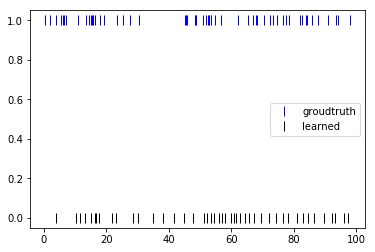

In [475]:
plt.figure(1)                # the first figure
plt.subplot(111)             # the first subplot in the first figure
plt.plot(points_thinned,np.ones(len(points_thinned)),linestyle='None', marker='|', color='b', markersize=10,label='groudtruth')
plt.plot(xxx,np.zeros(len(xxx)),linestyle='None', marker='|', color='k', markersize=10,label='learned')
plt.legend()
plt.show()

In [254]:
xxx,mean,cov=GP_regression(np.array(points_inhomo+list(s_m)),g_mk,theta0,theta1,noise_var,T,1000)

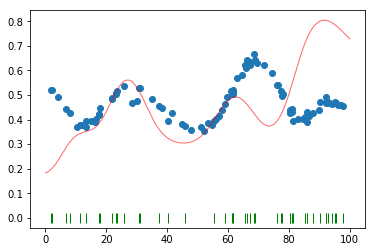

In [479]:
plt.figure(1)                # the first figure
plt.subplot(111)             # the first subplot in the first figure
# plt.plot(xxx,sigmoid(mean))
plt.scatter(np.array(points_inhomo+list(xxx)),sigmoid(np.array(list(yyy_1)+list(yyy))))
plt.plot(x,intensity,'r-',lw=1,alpha=0.6)
plt.plot(points_inhomo,np.zeros(len(points_inhomo)),linestyle='None', marker='|', color='g', markersize=10,label='inhomogeneous')
plt.show()

### points_thinned are fixed

In [231]:
g_mk_list=[]
for i in range(100):
    M,s_m,g_mk=sampling_g_mk(len(points_thinned),points_thinned,g_mk,measure_sup,T,1,0.01,0.01)  
    g_mk_list.append(g_mk)

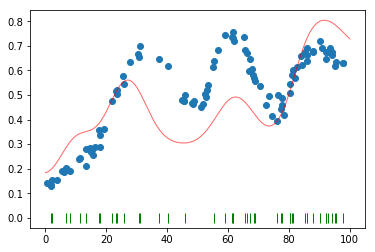

In [235]:
plt.figure(1)                # the first figure
plt.subplot(111)             # the first subplot in the first figure
plt.scatter(points_inhomo+points_thinned,sigmoid(np.average(np.array(g_mk_list),axis=0)))
plt.plot(x,intensity,'r-',lw=1,alpha=0.6)
plt.plot(points_inhomo,np.zeros(len(points_inhomo)),linestyle='None', marker='|', color='g', markersize=10,label='inhomogeneous')
plt.show()

### # of thinned points is fixed

In [141]:
M=len(points_thinned)
K=len(points_inhomo)
s_m=np.linspace(0.1,T-0.1,M)
g_mk=np.zeros((M+K))## 0--(K-1) observe K--last unobserve

In [142]:
theta0=1
theta1=0.01
noise_var=0.01

In [143]:
%%time
for i in range(1):
    M,s_m,g_mk=sampling_s_m(M,s_m,g_mk,measure_sup,T,theta0,theta1,noise_var) # sampling s_m
    M,s_m,g_mk=sampling_g_mk(M,s_m,g_mk,measure_sup,T,theta0,theta1,noise_var) # sampling g_mk

Wall time: 5.99 s


In [144]:
for i in range(500):
    M,s_m,g_mk=sampling_s_m(M,s_m,g_mk,measure_sup,T,theta0,theta1,noise_var) # sampling s_m
    M,s_m,g_mk=sampling_g_mk(M,s_m,g_mk,measure_sup,T,theta0,theta1,noise_var) # sampling g_mk

In [145]:
s_m_list=[]
g_mk_list=[]
for i in range(100):
    M,s_m,g_mk=sampling_s_m(M,s_m,g_mk,measure_sup,T,theta0,theta1,noise_var) # sampling s_m
    M,s_m,g_mk=sampling_g_mk(M,s_m,g_mk,measure_sup,T,theta0,theta1,noise_var) # sampling g_mk
    s_m_list.append(s_m)
    g_mk_list.append(g_mk)

In [146]:
len(g_mk_list)

100

In [147]:
def s_m_g_m_sort_average(s_m_list,g_mk_list):
    N=len(s_m_list)
    y=np.array(g_mk_list)[:,K:]
    x=np.array(s_m_list)
    y=np.array([y[i][x.argsort()[i]] for i in range(N)])
    x=np.sort(x)
    x=np.average(x,axis=0)
    y=np.average(y,axis=0)
    y_k=np.average(np.array(g_mk_list)[:,:K],axis=0)
    return x,y,y_k

In [148]:
s_m_sort_ave,g_m_sort_ave,g_k_ave=s_m_g_m_sort_average(s_m_list,g_mk_list)

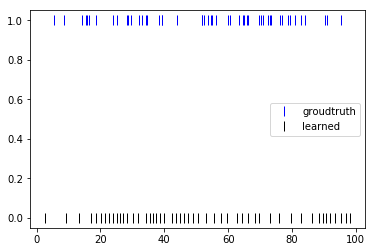

In [149]:
plt.figure(1)                # the first figure
plt.subplot(111)             # the first subplot in the first figure
plt.plot(points_thinned,np.ones(M),linestyle='None', marker='|', color='b', markersize=10,label='groudtruth')
plt.plot(s_m_sort_ave,np.zeros(M),linestyle='None', marker='|', color='k', markersize=10,label='learned')
plt.legend()
plt.show()

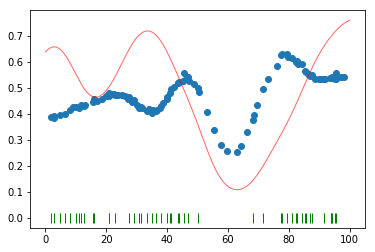

In [150]:
plt.figure(1)
plt.subplot(111)
plt.scatter(points_inhomo+list(s_m_sort_ave),measure_sup*sigmoid(np.array(list(g_k_ave)+list(g_m_sort_ave))))
plt.plot(x,intensity,'r-',lw=1,alpha=0.6)
plt.plot(points_inhomo,np.zeros(len(points_inhomo)),linestyle='None', marker='|', color='g', markersize=10)
plt.show()